# Se implementa el modelo propuesto en el articulo "Trading Bitcoin and online Time Series prediction"

In [2]:
import pandas as pd
import numpy as np
import gc
from binance.client import Client
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dense, Dropout
from sklearn.model_selection import train_test_split
import random

/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
def get_data(api_key, api_secret, initial_date, final_date, pair, time_frame):
    
    '''Returns a DataFrame that contains all the information about the 
       historical price of a pair of cryptocurrencies '''
    
    client = Client(api_key, api_secret)
    klines = client.get_historical_klines(pair , time_frame, initial_date, final_date)
    information = np.array(klines, dtype=float)
    df = pd.DataFrame(information, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time',
             'Quote asset volume', 'Number of trades', 'Taker buy base asset volume',
             'Taker buy quote asset volume', 'Can be ignored'])
    df['Open time'] = pd.to_datetime(df['Open time'], utc=True, unit='ms')
    df['Close time'] = pd.to_datetime(df['Close time'], utc=True, unit='ms')
    #df.isnull().values.any()
    return df

def plot_figure(label1, label2):
    '''Graph label1 as a function of label2'''
    plt.figure(figsize=(20,8))
    plt.grid(True)
    plt.plot(label1, label2)
    plt.xlabel(label1.name)
    plt.ylabel(label2.name)
    #plt.title('Close Prices 2017-12-01 and 2018-01-01')
    plt.show()
    
#Funciones para generar los datos de entrenamiento, las listas con los labels para entrenar etc
def Propuesta_Articulo_Atributos(Data_DF,Window,Theta_Pri,Interval_Information,Interval_Correlation):
    
    #Informacion sobre el precio
    Close_Price_DF = Data_DF['Close'].copy()
    Close_Price = Close_Price_DF.values
    #Size_Of_DS = len(Close_Price)
    Change_Price_1 = Close_Price.copy()
    for ii in range(len(Change_Price_1)):
        Change_Price_1[ii]=Close_Price[ii]-Close_Price[ii-1]
    #Change_Price_1 guarda la información del cambio en el precio en un paso de tiempo P[t]-P[t-1], luego, la información
    #es irrelevante para la primera entrada, ya que compara la primera entrada de la lista con la ultima.
    
    #Indicator_Change_Price guarda la información del indicador del cambio del precio
    #Theta_Close_Price es el threshold impuesto para clasificar el cambio en el precio
    Theta_Close_Price = Theta_Pri
    Indicator_Change_Price = np.ndarray(shape=(len(Change_Price_1)))
    for ii in range(len(Change_Price_1)):
        if Change_Price_1[ii]>Theta_Close_Price:
            Indicator_Change_Price[ii]=1
        elif Change_Price_1[ii]<-Theta_Close_Price:
            Indicator_Change_Price[ii]=-1
        else:
            Indicator_Change_Price[ii]=0

    #Tally count guarda la información de la cantidad de subidas, bajadas o comportamientos estacionarios del precio
    Tally_Count = np.ndarray(shape=(len(Close_Price),3,Window))
    for ii in range(len(Close_Price)):
        #Para cada clasificación en el cambio del precio
        for jj in range(3):
            #Para cada profundidad
            for kk in range(Window):
                Tally_Count[ii,jj,kk]=0
                for ll in range(kk+1):
                    if int(Indicator_Change_Price[ii-(ll+1)])==jj-1:
                        Tally_Count[ii,jj,kk]+=1

    #Last trend guarda la información de la ultima tendencia
    Last_trend = np.ndarray(shape=(len(Close_Price),3))
    for ii in range(len(Close_Price)):
        for jj in range(3):
            Last_trend[ii,jj]=0
            kk=0
            if int(Indicator_Change_Price[ii-1])==jj-1:
                while int(Indicator_Change_Price[ii-1])==int(Indicator_Change_Price[ii-1-kk]) and kk<Window:
                    Last_trend[ii,jj]+=1
                    kk+=1
    
    
    #Lista que guardará la información del nombre de las columnas
    #Atributos
    columns_DF = []
    #Change in price
    columns_DF.append('Close_Price_1_t-1')
    for ii in range(Interval_Correlation):
        columns_DF.append('Change_Price_t-'+str(ii+1))
    for ii in range(3):
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                columns_DF.append('Tally_Count_'+str(ii-1)+'_t-'+str(jj+1))
    for ii in range(3):
        columns_DF.append('Last_trend_'+str(ii-1))
    #Clasificación
    columns_DF.append('Clasiffication')    

    #Lista que contiene el nombre de los atributos para hacer la clasificación
    Features_Headers = columns_DF[:-1].copy()
    
    #Lista que contiene el nombre de la caracteristica a clasificar
    Target_Header = []
    Target_Header.append('Clasiffication')
    
    #Arreglo con la información para hacer la clasificación
    Organized_Data = np.ndarray(shape=(len(Close_Price)-(Window+1),len(columns_DF)))
    
    for ii in range(len(Close_Price)-(Window+1)):
        Contador=0
        #information about the price
        #Close price in the last time normalized to maximum value of the price
        Organized_Data[ii,0]=Close_Price[ii+(Window+1)-1]/np.amax(Close_Price)
        Contador+=1
        #Cambio en el precio normalizado
        for jj in range(Interval_Correlation):
            Organized_Data[ii,jj+1]=Change_Price_1[ii+(Window+1)-(jj+1)]/Close_Price[ii+(Window+1)-(jj+2)] #Indicator_Change_Price[ii+(Window+1)-(jj+1)] 
            Contador+=1
        #Tally count
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                Organized_Data[ii,Contador]=Tally_Count[ii+(Window+1),0,jj]
                Contador+=1
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                Organized_Data[ii,Contador]=Tally_Count[ii+(Window+1),1,jj]
                Contador+=1
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                Organized_Data[ii,Contador]=Tally_Count[ii+(Window+1),2,jj]
                Contador+=1
        #Last trend
        Organized_Data[ii,Contador]=Last_trend[ii+(Window+1)][0]
        Contador+=1
        Organized_Data[ii,Contador]=Last_trend[ii+(Window+1)][1]
        Contador+=1
        Organized_Data[ii,Contador]=Last_trend[ii+(Window+1)][2] 
        Contador+=1
        
        #Clasiffication
        Organized_Data[ii,Contador]=Indicator_Change_Price[ii+(Window_Lengt+1)]
    
    #print(Organized_Data.shape)
    #print(len(columns_DF))
    
    #DataFrame con la información requerida para entrenar los modelos
    Price_DF = pd.DataFrame(Organized_Data, columns=columns_DF)
    
    return Price_DF,Organized_Data,columns_DF,Features_Headers,Target_Header,Change_Price_1,Indicator_Change_Price,Tally_Count,Last_trend,Close_Price


#Funciones para generar los datos de entrenamiento, las listas con los labels para entrenar etc
#Se tienen en cuenta el volumen y el precio
def Propuesta_Articulo_Atributos_2(Data_DF,Window,Theta_Pri,Theta_Vol,Interval_Information,Interval_Correlation):
    
    #Informacion sobre el precio
    Close_Price_DF = Data_DF['Close'].copy()
    Close_Price = Close_Price_DF.values
    #Size_Of_DS = len(Close_Price)
    Change_Price_1 = Close_Price.copy()
    for ii in range(len(Change_Price_1)):
        Change_Price_1[ii]=Close_Price[ii]-Close_Price[ii-1]
    #Change_Price_1 guarda la información del cambio en el precio en un paso de tiempo P[t]-P[t-1], luego, la información
    #es irrelevante para la primera entrada, ya que compara la primera entrada de la lista con la ultima.
    
    #Indicator_Change_Price guarda la información del indicador del cambio del precio
    #Theta_Close_Price es el threshold impuesto para clasificar el cambio en el precio
    Theta_Close_Price = Theta_Pri
    Indicator_Change_Price = np.ndarray(shape=(len(Change_Price_1)))
    for ii in range(len(Change_Price_1)):
        if Change_Price_1[ii]>Theta_Close_Price:
            Indicator_Change_Price[ii]=1
        elif Change_Price_1[ii]<-Theta_Close_Price:
            Indicator_Change_Price[ii]=-1
        else:
            Indicator_Change_Price[ii]=0

    #Tally count guarda la información de la cantidad de subidas, bajadas o comportamientos estacionarios del precio
    Tally_Count = np.ndarray(shape=(len(Close_Price),3,Window))
    for ii in range(len(Close_Price)):
        #Para cada clasificación en el cambio del precio
        for jj in range(3):
            #Para cada profundidad
            for kk in range(Window):
                Tally_Count[ii,jj,kk]=0
                for ll in range(kk+1):
                    if int(Indicator_Change_Price[ii-(ll+1)])==jj-1:
                        Tally_Count[ii,jj,kk]+=1

    #Last trend guarda la información de la ultima tendencia
    Last_trend = np.ndarray(shape=(len(Close_Price),3))
    for ii in range(len(Close_Price)):
        for jj in range(3):
            Last_trend[ii,jj]=0
            kk=0
            if int(Indicator_Change_Price[ii-1])==jj-1:
                while int(Indicator_Change_Price[ii-1])==int(Indicator_Change_Price[ii-1-kk]) and kk<Window:
                    Last_trend[ii,jj]+=1
                    kk+=1
    
    #Información sobre el volumen
    Volume_DF = Data_DF['Volume'].copy()
    Volume = Volume_DF.values
    Change_Volume_1 = Volume.copy()
    for ii in range(len(Change_Volume_1)):
        Change_Volume_1[ii]=(Volume[ii]-Volume[ii-1])#/Volume[ii-1]

    #Indicator_Change_Volume guarda la información del indicador del cambio del precio
    #Theta_Volume es el threshold impuesto para clasificar el cambio en el Volumen
    Theta_Volume = Theta_Vol
    Indicator_Change_Volume = np.ndarray(shape=(len(Change_Volume_1)))
    for ii in range(len(Change_Volume_1)):
        if Change_Volume_1[ii]>Theta_Volume:
            Indicator_Change_Volume[ii]=1
        elif Change_Volume_1[ii]<-Theta_Volume:
            Indicator_Change_Volume[ii]=-1
        else:
            Indicator_Change_Volume[ii]=0

    #Tally_Count_Volume guarda la información de la cantidad de subidas, bajadas o comportamientos estacionarios del precio
    Tally_Count_Volume = np.ndarray(shape=(len(Volume),3,Window_Lengt))
    for ii in range(len(Volume)):
        #Para cada clasificación en el cambio del precio
        for jj in range(3):
            #Para cada profundidad
            for kk in range(Window_Lengt):
                Tally_Count_Volume[ii,jj,kk]=0
                for ll in range(kk+1):
                    if int(Indicator_Change_Volume[ii-(ll+1)])==jj-1:
                        Tally_Count_Volume[ii,jj,kk]+=1

    #Last trend guarda la información de la ultima tendencia
    Last_trend_Volume = np.ndarray(shape=(len(Volume),3))
    for ii in range(len(Volume)):
        for jj in range(3):
            Last_trend_Volume[ii,jj]=0
            kk=0
            if int(Indicator_Change_Volume[ii-1])==jj-1:
                while int(Indicator_Change_Volume[ii-1])==int(Indicator_Change_Volume[ii-1-kk]) and kk<Window_Lengt:
                    Last_trend_Volume[ii,jj]+=1
                    kk+=1
    

    #Lista que guardará la información del nombre de las columnas
    #Atributos
    columns_DF = []
    #Change in price
    columns_DF.append('Close_Price_1_t-1')
    for ii in range(Interval_Correlation):
        columns_DF.append('Change_Price_t-'+str(ii+1))
    for ii in range(3):
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                columns_DF.append('Tally_Count_'+str(ii-1)+'_t-'+str(jj+1))
    for ii in range(3):
        columns_DF.append('Last_trend_'+str(ii-1))
    #Change in Volume
    columns_DF.append('Volume_t-1')
    for ii in range(Interval_Correlation):
        columns_DF.append('Change_Volume_t-'+str(ii+1))
    for ii in range(3):
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                columns_DF.append('Tally_Count_Volume_'+str(ii-1)+'_t-'+str(jj+1))
    for ii in range(3):
        columns_DF.append('Last_trend_Volume_'+str(ii-1))
    #Clasificación
    columns_DF.append('Clasiffication')    

    #Lista que contiene el nombre de los atributos para hacer la clasificación
    Features_Headers = columns_DF[:-1].copy()
    
    #Lista que contiene el nombre de la caracteristica a clasificar
    Target_Header = []
    Target_Header.append('Clasiffication')
    
    #Arreglo con la información para hacer la clasificación
    Organized_Data = np.ndarray(shape=(len(Close_Price)-(Window+1),len(columns_DF)))
    
    for ii in range(len(Close_Price)-(Window+1)):
        Contador=0
        #information about the price
        #Close price in the last time normalized to maximum value of the price
        Organized_Data[ii,0]=Close_Price[ii+(Window+1)-1]/np.amax(Close_Price)
        Contador+=1
        #Cambio en el precio normalizado
        for jj in range(Interval_Correlation):
            Organized_Data[ii,jj+1]=Change_Price_1[ii+(Window+1)-(jj+1)]/Close_Price[ii+(Window+1)-(jj+2)] #Indicator_Change_Price[ii+(Window+1)-(jj+1)] #Change_Price_1[ii+(Window+1)-(jj+1)]/Close_Price[ii+(Window+1)-(jj+2)]
            Contador+=1
        #Tally count
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                Organized_Data[ii,Contador]=Tally_Count[ii+(Window+1),0,jj]
                Contador+=1
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                Organized_Data[ii,Contador]=Tally_Count[ii+(Window+1),1,jj]
                Contador+=1
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                Organized_Data[ii,Contador]=Tally_Count[ii+(Window+1),2,jj]
                Contador+=1
        #Last trend
        Organized_Data[ii,Contador]=Last_trend[ii+(Window+1)][0]
        Contador+=1
        Organized_Data[ii,Contador]=Last_trend[ii+(Window+1)][1]
        Contador+=1
        Organized_Data[ii,Contador]=Last_trend[ii+(Window+1)][2] 
        Contador+=1
        
        #Information about the volume
        #Close price in the last time normalized to maximum value of the Volume
        Organized_Data[ii,Contador]=Volume[ii+(Window+1)-1]/np.amax(Volume)
        Contador+=1
        #Cambio en el precio normalizado
        for jj in range(Interval_Correlation):
            Organized_Data[ii,Contador]=Change_Volume_1[ii+(Window+1)-(jj+1)]/Volume[ii+(Window+1)-(jj+2)] #Indicator_Change_Volume[ii+(Window+1)-(jj+1)] #Change_Volume_1[ii+(Window+1)-(jj+1)]/Volume[ii+(Window+1)-(jj+2)]
            Contador+=1
        #Tally count
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                Organized_Data[ii,Contador]=Tally_Count_Volume[ii+(Window+1),0,jj]
                Contador+=1
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                Organized_Data[ii,Contador]=Tally_Count_Volume[ii+(Window+1),1,jj]
                Contador+=1
        for jj in range(Window):
            if (jj+1)%Interval_Information==0:
                Organized_Data[ii,Contador]=Tally_Count_Volume[ii+(Window+1),2,jj]
                Contador+=1
        #Last trend
        Organized_Data[ii,Contador]=Last_trend_Volume[ii+(Window+1)][0]
        Contador+=1
        Organized_Data[ii,Contador]=Last_trend_Volume[ii+(Window+1)][1]
        Contador+=1
        Organized_Data[ii,Contador]=Last_trend_Volume[ii+(Window+1)][2] 
        Contador+=1
        
        #Clasiffication
        Organized_Data[ii,Contador]=Indicator_Change_Price[ii+(Window_Lengt+1)]
    
    #print(Organized_Data.shape)
    #print(len(columns_DF))
    
    #DataFrame con la información requerida para entrenar los modelos
    Price_DF = pd.DataFrame(Organized_Data, columns=columns_DF)
    
    return Price_DF,Organized_Data,columns_DF,Features_Headers,Target_Header,Change_Price_1,Indicator_Change_Price,Tally_Count,Last_trend,Close_Price

#Esta funcion retorna la historia de la inversión realizada para una estrategia de trading simple implementada
#con un clasificador
def Ganancia(Predictions,Probabilities_of_Predictions,Y_test,P1,P2,Window_Lengt,Close_Price,Threshold,Indices):
    
    #Historia de las transacciones
    History_Transactions = np.ndarray(shape=(len(Predictions)))
    
    #Se determina cuales transacciones son admitidas
    Admited_Predictions=Predictions.copy()
    for jj in range(len(Predictions)):
        if Probabilities_of_Predictions[jj][Predictions[jj]+1]>Threshold:
            Admited_Predictions[jj]=Predictions[jj]
        else:
            Admited_Predictions[jj]=0
            
    #Se calcula el porcentaje de ganancia para una estrategia simple de trading
    BTC=1.0
    Dolares=0.0
    Total=BTC*Close_Price[Indices[0]+Window_Lengt]+Dolares
    Inversion_Incial=Total
    Movimientos=0
    for jj in range(len(Admited_Predictions)):
        if Admited_Predictions[jj]==1:
            #Si se compra y el mercado baja la posicion se cierra en una hora
            if Y_test[jj]==-1:
                BTC+=Dolares/(Close_Price[Indices[jj]+Window_Lengt])
                Dolares=0.0
                Movimientos+=1
            #Si se compra y el mercado sube es posible que no se cierre la posición
            elif Y_test[jj]==1:
                if random.random()<P1:#abs(Change_Price_1[Indices[jj]+Window_Lengt]/Change_Price_1[Indices[jj]+Window_Lengt+1]):
                    BTC+=Dolares/(Close_Price[Indices[jj]+Window_Lengt])#+10*Probabilities_of_Predictions_NN[jj][Predictions_NN[jj]+1])
                    Dolares=0.0
                    Movimientos+=1
            #Si el compra y el mercado no cambia se cierra la posición máximo en dos horas
            elif Y_test[jj]==0:
                if random.random()<P2:#0.5*abs(Change_Price_1[Indices[jj]+Window_Lengt]/Change_Price_1[Indices[jj]+Window_Lengt+1]):
                    BTC+=Dolares/(Close_Price[Indices[jj]+Window_Lengt])#+10*Probabilities_of_Predictions_NN[jj][Predictions_NN[jj]+1])
                    Dolares=0.0
                    Movimientos+=1

        elif Admited_Predictions[jj]==-1:
            #Si se vende y el mercado sube la posicion se cierra en una hora
            if Y_test[jj]==1:
                Dolares+=BTC*(Close_Price[Indices[jj]+Window_Lengt])#-10*Probabilities_of_Predictions_NN[jj][Predictions_NN[jj]+1])
                BTC=0.0
                Movimientos+=1
            #Si se vende y el mercado baja es posible que no se cierre la posición
            elif Y_test[jj]==-1: 
                if random.random()<P1:#abs(Change_Price_1[Indices[jj]+Window_Lengt]/Change_Price_1[Indices[jj]+Window_Lengt+1]):
                    Dolares+=BTC*(Close_Price[Indices[jj]+Window_Lengt])#-10*Probabilities_of_Predictions_NN[jj][Predictions_NN[jj]+1])
                    BTC=0.0
                    Movimientos+=1
            #Si se compra y el mercado baje se cierra la posicion maximo en dos horas:
            elif Y_test[jj]==0:
                if random.random()<P2:#0.5*abs(Change_Price_1[Indices[jj]+Window_Lengt]/Change_Price_1[Indices[jj]+Window_Lengt+1]):
                    Dolares+=BTC*(Close_Price[Indices[jj]+Window_Lengt])#-10*Probabilities_of_Predictions_NN[jj][Predictions_NN[jj]+1])
                    BTC=0.0
                    Movimientos+=1

        Total=Dolares+BTC*Close_Price[Indices[jj]+Window_Lengt+1]
        #Guardar la informacion
        History_Transactions[jj]=Total
        
    return History_Transactions,Movimientos


#Se calcula la ganancia de un clasificador en función del Threshold para escoger
#qué transacciones realizar
def Ganancia_Vs_Threshold(Clasificador,Y_test,X_test,P1,P2,Indices,Window_Lengt,Close_Price):
    step=0.001
    Confidence_Threshold = np.ndarray(shape=(int((0.95-0.4)/step)))
    Efectividad_Porcetaje_Ganancia = np.ndarray(shape=(int((0.95-0.4)/step)))
    Cantidad_Trades = np.ndarray(shape=(int((0.95-0.4)/step)))
    #Predicciones
    Predictions=Clasificador.predict(X_test)
    Probabilities_of_Predictions=Clasificador.predict_proba(X_test)
    #Predicciones admitidas
    Admited_Predictions = Predictions.copy()
    #Inversion inicial
    BTC=1.0
    Dolares=0.0
    Total=BTC*Close_Price[Indices[0]+Window_Lengt]+Dolares
    Inversion_Incial=Total
    #Se itera sobre todos los valores del Threshold
    for ii in range(len(Confidence_Threshold)):
        Confidence_Threshold[ii]=0.4+ii*step
        History,Movimientos=Ganancia(Predictions,Probabilities_of_Predictions,Y_test,P1,P2,Window_Lengt,Close_Price,Confidence_Threshold[ii],Indices)
        Cantidad_Trades[ii]=Movimientos
        Efectividad_Porcetaje_Ganancia[ii]=(History[-1]-Inversion_Incial)/Inversion_Incial   
        
    return Confidence_Threshold,Efectividad_Porcetaje_Ganancia,Cantidad_Trades

In [4]:
api_key = 'IbpsF5kqc5Jr34cPrYtugWoIuuVf05GokqOC0TcS35mwtpb5UpsaST1fePtRJL7F'
api_secret = 'kvWWitpU5fFMtucgr0YYIV0Z33Y1EwfEBRc57ey0G5UzHMmKgdWer8G1pwkWmjuc'
initial_date ='1 Dec, 2015'
final_date ='1 Jan, 2019'
pair = "BTCUSDT"
time_frame = Client.KLINE_INTERVAL_1HOUR

In [5]:
data = get_data(api_key, api_secret, initial_date, final_date, pair, time_frame)
#Window lengt es la cantidad de pasos anteriores que se consideran importantes
#Window_Lengt = 3

In [6]:
#Constantes para el modelo ajustadas después de variaas pruebas ya que dan el mejor 
# retorno porcentual promedio; estas constantes pueden ser parámetros que identifican diferentes clasificadores 
Window_Lengt=9
Interval_Correlation=6
Lengt_Interval_Information=3
Theta_Pr=2.0
Theta_Vl=10.0

#Atributos propuestos por nosotros, estos atributos incluyen los datos de la serie de tiempo del precio de cierre
#y la serie de tiempo del volumen
Price_DF_FA,Organized_Data_FA,columns_DF_FA,Features_Headers_FA,Target_Header_FA,Change_Price_1_FA,Indicator_Change_Price_FA,Tally_Count_FA,Last_Trend_FA,Close_Price_FA = Propuesta_Articulo_Atributos_2(data,Window_Lengt,Theta_Pr,Theta_Vl,Lengt_Interval_Information,Interval_Correlation)

#Atributos propuestos en el artículo que se está reproduciendo, estos incluyen los datos de la serie de tiempo
#del precio de cierre
Price_DF,Organized_Data,columns_DF,Features_Headers,Target_Header,Change_Price_1,Indicator_Change_Price,Tally_Count,Last_Trend,Close_Price = Propuesta_Articulo_Atributos(data,Window_Lengt,Theta_Pr,Lengt_Interval_Information,Interval_Correlation)


In [7]:
#Se dividen los datos en Training, Validation y Test (0.8,0.1,0.1)
#Propuesta de atributos nuestra
Train_X_DF_FA, Test_Validation_X_DF_FA, Train_Y_DF_FA, Test_Validation_Y_DF_FA = train_test_split(Price_DF_FA[Features_Headers_FA], Price_DF_FA[Target_Header_FA],
                                                        train_size=0.8,shuffle=False)

Validation_X_DF_FA, Test_X_DF_FA, UNO, DOS = train_test_split(Test_Validation_X_DF_FA[Features_Headers_FA], Test_Validation_X_DF_FA[[]],
                                                        train_size=0.5,shuffle=False)

UNO, DOS, Validation_Y_DF_FA, Test_Y_DF_FA = train_test_split(Test_Validation_Y_DF_FA[[]], Test_Validation_Y_DF_FA[Target_Header_FA],
                                                        train_size=0.5,shuffle=False)


#Propuesta de atributos del artículo
Train_X_DF, Test_Validation_X_DF, Train_Y_DF, Test_Validation_Y_DF = train_test_split(Price_DF[Features_Headers], Price_DF[Target_Header],
                                                        train_size=0.8,shuffle=False)

Validation_X_DF, Test_X_DF, UNO, DOS = train_test_split(Test_Validation_X_DF[Features_Headers], Test_Validation_X_DF[[]],
                                                        train_size=0.5,shuffle=False)

UNO, DOS, Validation_Y_DF, Test_Y_DF = train_test_split(Test_Validation_Y_DF[[]], Test_Validation_Y_DF[Target_Header],
                                                        train_size=0.5,shuffle=False)


#Crear un ndarray con la información de la clasificación en tipo entero

#Datos de entrenamiento
#Propuesta articulo
Training = Train_Y_DF['Clasiffication'].values
Data_Y_Train = np.ndarray(shape=(len(Training)),dtype=int)
for ii in range(len(Training)):
    Data_Y_Train[ii]=int(Training[ii])
#Propuesta nuestra
Training = Train_Y_DF_FA['Clasiffication'].values
Data_Y_Train_FA = np.ndarray(shape=(len(Training)),dtype=int)
for ii in range(len(Training)):
    Data_Y_Train_FA[ii]=int(Training[ii])

#Datos de Validación 
#Propuesta articulo
Validation = Validation_Y_DF['Clasiffication'].values
Data_Y_Validation = np.ndarray(shape=(len(Validation)),dtype=int)
for ii in range(len(Validation)):
    Data_Y_Validation[ii]=int(Validation[ii])
#Propuesta nuestra
Validation = Validation_Y_DF_FA['Clasiffication'].values
Data_Y_Validation_FA = np.ndarray(shape=(len(Validation)),dtype=int)
for ii in range(len(Validation)):
    Data_Y_Validation_FA[ii]=int(Validation[ii])
    
#Datos de testeo
#Propuesta articulo
Testing = Test_Y_DF['Clasiffication'].values
Data_Y_Test = np.ndarray(shape=(len(Testing)),dtype=int)
for ii in range(len(Testing)):
    Data_Y_Test[ii]=int(Testing[ii])
#Propuesta nuestra
Testing = Test_Y_DF_FA['Clasiffication'].values
Data_Y_Test_FA = np.ndarray(shape=(len(Testing)),dtype=int)
for ii in range(len(Testing)):
    Data_Y_Test_FA[ii]=int(Testing[ii])

#Indices 
Indices_Validation_FA=Validation_Y_DF_FA.index
Indices_Test_FA=Test_Y_DF_FA.index
Indices_Validation=Validation_Y_DF.index
Indices_Test=Test_Y_DF.index

/home/juanchoflo/Tensorflow_Py3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


## Random forest classifier

In [8]:
# Load scikit's random forest classifier library
from sklearn.ensemble import RandomForestClassifier
#Load scikit's train_test_split library
from sklearn.model_selection import train_test_split
#Load libraries to test the presicion of the classifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
# Set random seed
np.random.seed(0)

### Atributos del artículo 

In [9]:
#Se crea el clasificador tipo Random Forest y se entrena
Random_Forest_CLS = RandomForestClassifier(n_estimators=800,max_depth=80)
Random_Forest_CLS.fit(Train_X_DF,Data_Y_Train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [10]:
print('Presicion para entrenamiento: ',accuracy_score(Data_Y_Train, Random_Forest_CLS.predict(Train_X_DF)))
print('Presicion para testeo: ',accuracy_score(Data_Y_Validation,Random_Forest_CLS.predict(Validation_X_DF)))

Presicion para entrenamiento:  1.0
Presicion para testeo:  0.5328571428571428


In [11]:
P1=1.0
P2=1.0
Confidence_Threshold,Efectividad_Porcetaje_Ganancia,Cantidad_Trades=Ganancia_Vs_Threshold(Random_Forest_CLS,Data_Y_Validation,Validation_X_DF,P1,P2,Indices_Validation,Window_Lengt,Close_Price)

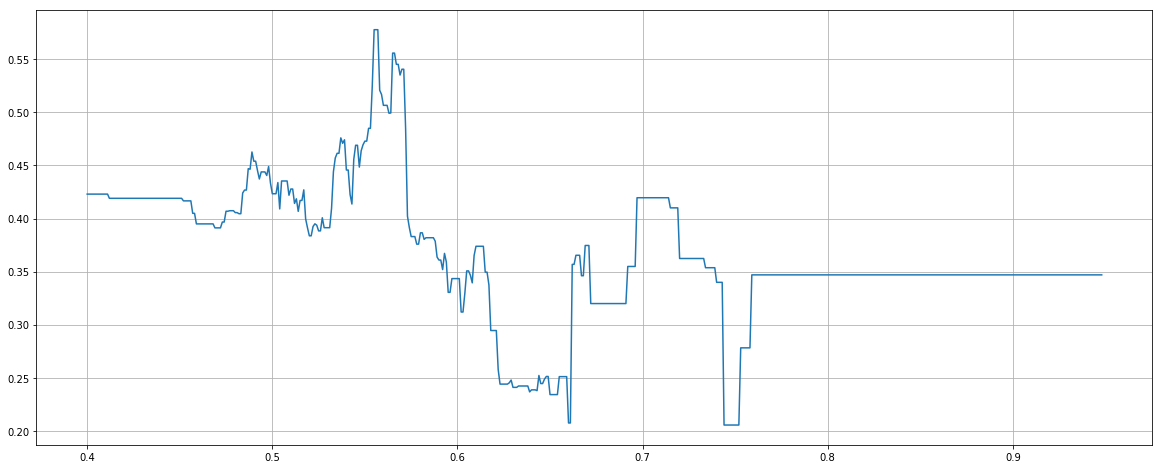

In [12]:
plt.figure(figsize=(20,8))
plt.plot(Confidence_Threshold,Efectividad_Porcetaje_Ganancia)
plt.grid(True)
plt.show()

In [13]:
Threshold=Confidence_Threshold[np.argmax(Efectividad_Porcetaje_Ganancia)]
Threshold

0.555

In [14]:
#Se observa cómo el algoritmo se comporta en el conjunto de testeo
Predictions = Random_Forest_CLS.predict(Test_X_DF)
Probabilities_of_Predictions = Random_Forest_CLS.predict_proba(Test_X_DF)
P1=1.0
P2=1.0
History, Movimientos = Ganancia(Predictions,Probabilities_of_Predictions,Data_Y_Test,P1,P2,Window_Lengt,Close_Price,Threshold,Indices_Test)

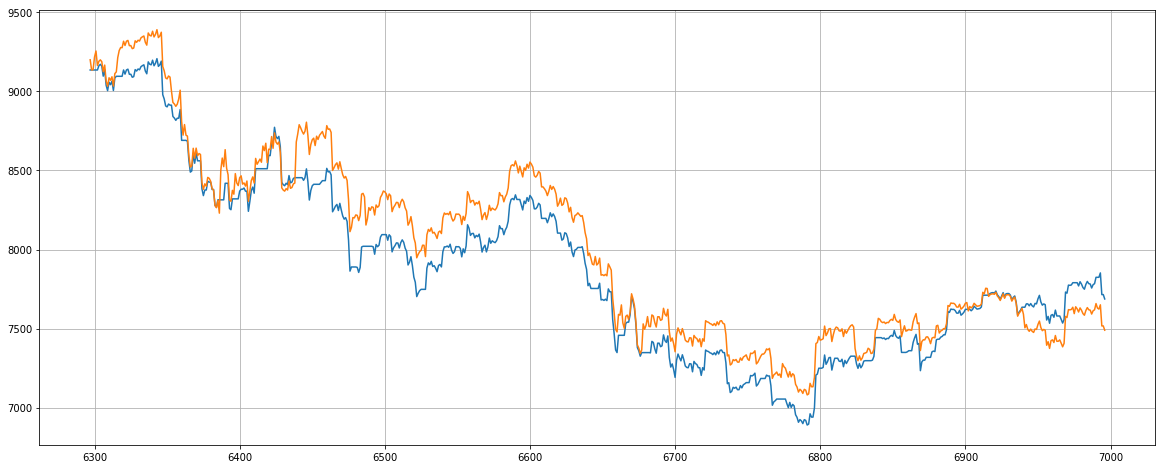

In [15]:
plt.figure(figsize=(20,8))
plt.plot(Indices_Test,History)
plt.plot(Indices_Test,Close_Price[Indices_Test_FA[0]+Window_Lengt+1:])
plt.grid(True)
plt.show()

El clasificador no se comporta adecuadamente en esta sección de la serie.

### Modelo propuesto por nosotros 

In [16]:
#Se crea el clasificador tipo Random Forest y se entrena
Random_Forest_CLS = RandomForestClassifier(n_estimators=800,max_depth=80)
Random_Forest_CLS.fit(Train_X_DF_FA,Data_Y_Train_FA)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=80, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=800, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [115]:
print('Presicion para entrenamiento: ',accuracy_score(Data_Y_Train_FA, Random_Forest_CLS.predict(Train_X_DF_FA)))
print('Presicion para testeo: ',accuracy_score(Data_Y_Validation_FA,Random_Forest_CLS.predict(Validation_X_DF_FA)))

Presicion para entrenamiento:  1.0
Presicion para testeo:  0.5178826895565093


In [116]:
P1=1.0
P2=1.0
Confidence_Threshold,Efectividad_Porcetaje_Ganancia,Cantidad_Trades=Ganancia_Vs_Threshold(Random_Forest_CLS,Data_Y_Validation_FA,Validation_X_DF_FA,P1,P2,Indices_Validation_FA,Window_Lengt,Close_Price)

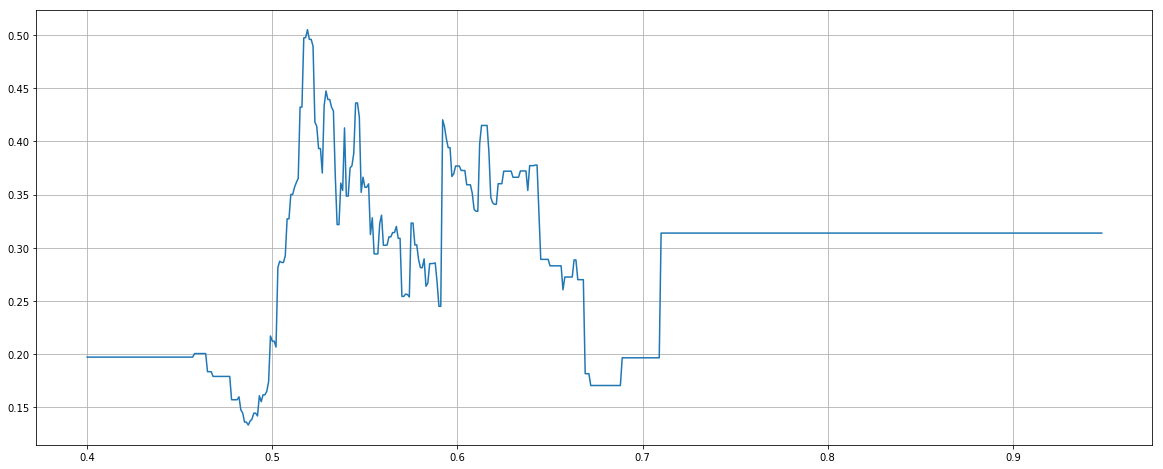

In [117]:
plt.figure(figsize=(20,8))
plt.plot(Confidence_Threshold,Efectividad_Porcetaje_Ganancia)
plt.grid(True)
plt.show()

In [118]:
Threshold=Confidence_Threshold[np.argmax(Efectividad_Porcetaje_Ganancia)]
Threshold

0.519

In [119]:
#Se observa cómo el algoritmo se comporta en el conjunto de testeo
Predictions = Random_Forest_CLS.predict(Test_X_DF_FA)
Probabilities_of_Predictions = Random_Forest_CLS.predict_proba(Test_X_DF_FA)
P1=1.0
P2=1.0
History, Movimientos = Ganancia(Predictions,Probabilities_of_Predictions,Data_Y_Test_FA,P1,P2,Window_Lengt,Close_Price_FA,Threshold,Indices_Test_FA)

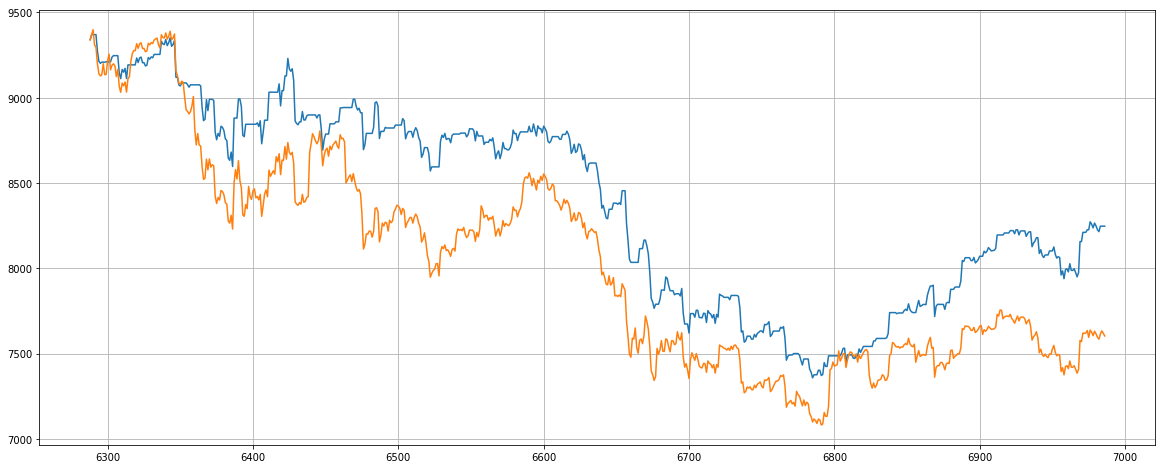

In [120]:
plt.figure(figsize=(20,8))
plt.plot(Indices_Test_FA,History)
plt.plot(Indices_Test_FA,Close_Price_FA[Indices_Test_FA[0]+Window_Lengt+1:])
plt.grid(True)
plt.show()

El clasificador no se comporta adecuadamente en esta sección de la serie.

## Logistic regression

In [17]:
from sklearn.linear_model import LogisticRegression

### Atributos del articulo 

In [18]:
#Se crea el clasificador tipo Logistic Regression y se entrena
Logistic_Regression_CLS = LogisticRegression(multi_class='multinomial',solver='newton-cg')#,tol=0.000001,max_iter=200)
Logistic_Regression_CLS.fit(Train_X_DF,Data_Y_Train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [19]:
print('Presicion para entrenamiento: ',accuracy_score(Data_Y_Train, Logistic_Regression_CLS.predict(Train_X_DF)))
print('Presicion para testeo: ',accuracy_score(Data_Y_Validation, Logistic_Regression_CLS.predict(Validation_X_DF)))

Presicion para entrenamiento:  0.5417187779167411
Presicion para testeo:  0.5342857142857143


In [20]:
P1=1.0
P2=1.0
Confidence_Threshold,Efectividad_Porcetaje_Ganancia,Cantidad_Trades=Ganancia_Vs_Threshold(Logistic_Regression_CLS,Data_Y_Validation,Validation_X_DF,P1,P2,Indices_Validation,Window_Lengt,Close_Price)

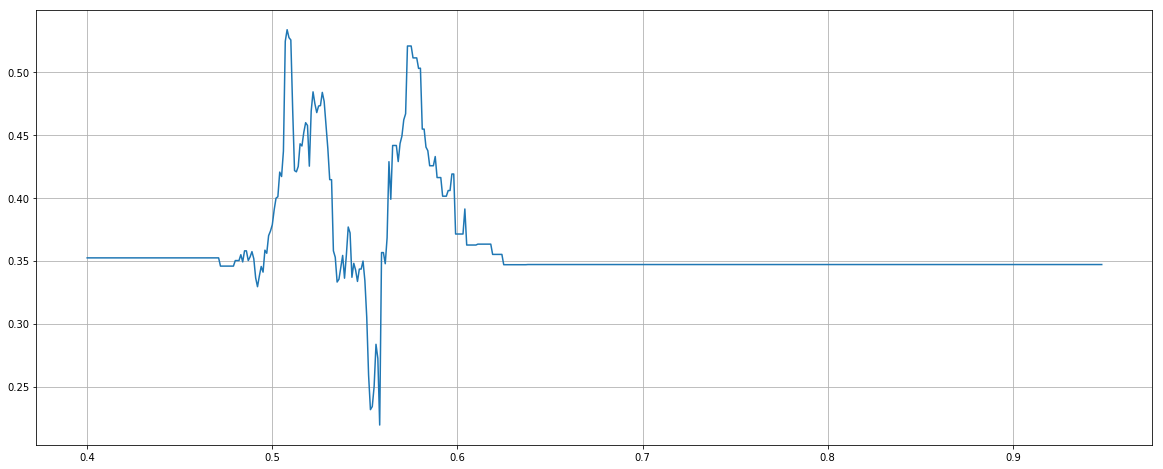

In [21]:
plt.figure(figsize=(20,8))
plt.plot(Confidence_Threshold,Efectividad_Porcetaje_Ganancia)
plt.grid(True)
plt.show()

In [22]:
Threshold=Confidence_Threshold[np.argmax(Efectividad_Porcetaje_Ganancia)]
Threshold

0.508

In [23]:
#Se observa cómo el algoritmo se comporta en el conjunto de testeo
Predictions = Logistic_Regression_CLS.predict(Test_X_DF)
Probabilities_of_Predictions = Logistic_Regression_CLS.predict_proba(Test_X_DF)
P1=1.0
P2=1.0
History, Movimientos = Ganancia(Predictions,Probabilities_of_Predictions,Data_Y_Test,P1,P2,Window_Lengt,Close_Price,Threshold,Indices_Test)

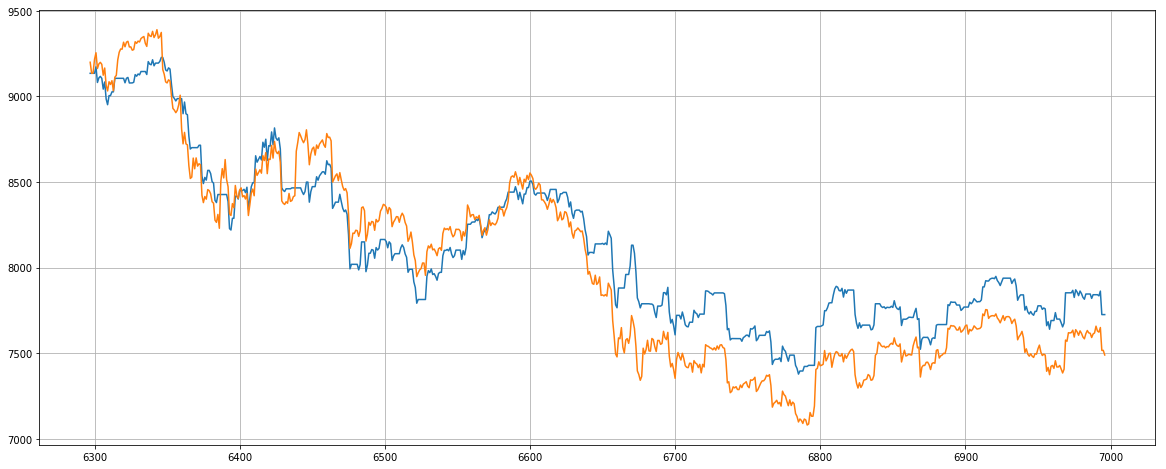

In [24]:
plt.figure(figsize=(20,8))
plt.plot(Indices_Test,History)
plt.plot(Indices_Test_FA,Close_Price_FA[Indices_Test[0]+Window_Lengt+1:])
plt.grid(True)
plt.show()

### Atributos propuestos por nosotros 

In [25]:
#Se crea el clasificador tipo Logistic Regression y se entrena
Logistic_Regression_CLS = LogisticRegression(multi_class='multinomial',solver='newton-cg')#,tol=0.000001,max_iter=200)
Logistic_Regression_CLS.fit(Train_X_DF_FA,Data_Y_Train_FA)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [26]:
print('Presicion para entrenamiento: ',accuracy_score(Data_Y_Train_FA, Logistic_Regression_CLS.predict(Train_X_DF_FA)))
print('Presicion para testeo: ',accuracy_score(Data_Y_Validation_FA, Logistic_Regression_CLS.predict(Validation_X_DF_FA)))

Presicion para entrenamiento:  0.5417187779167411
Presicion para testeo:  0.54


In [27]:
P1=1.0
P2=1.0
Confidence_Threshold,Efectividad_Porcetaje_Ganancia,Cantidad_Trades=Ganancia_Vs_Threshold(Logistic_Regression_CLS,Data_Y_Validation_FA,Validation_X_DF_FA,P1,P2,Indices_Validation_FA,Window_Lengt,Close_Price_FA)

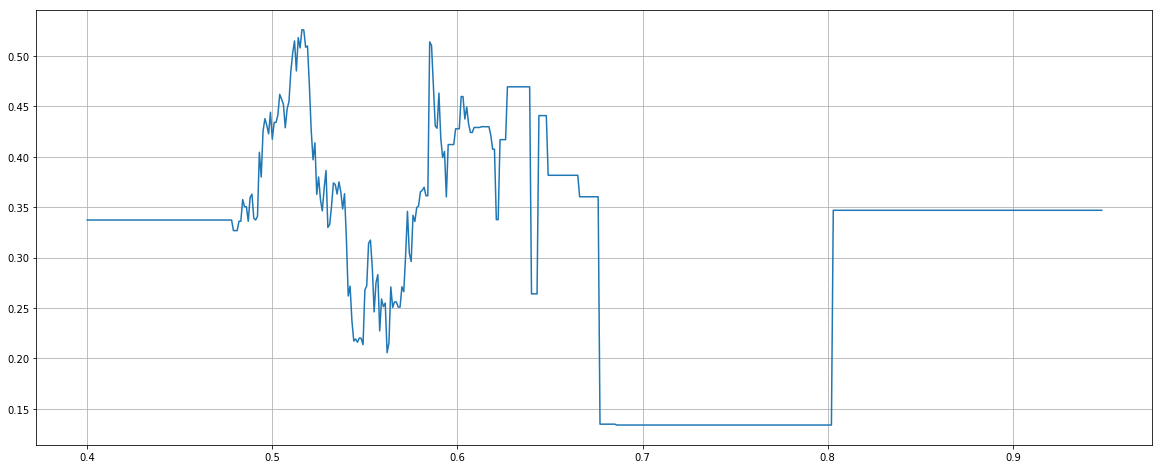

In [28]:
plt.figure(figsize=(20,8))
plt.plot(Confidence_Threshold,Efectividad_Porcetaje_Ganancia)
plt.grid(True)
plt.show()

In [29]:
Threshold=Confidence_Threshold[np.argmax(Efectividad_Porcetaje_Ganancia)]
Threshold

0.516

In [30]:
#Se observa cómo el algoritmo se comporta en el conjunto de testeo
Predictions = Logistic_Regression_CLS.predict(Test_X_DF_FA)
Probabilities_of_Predictions = Logistic_Regression_CLS.predict_proba(Test_X_DF_FA)
P1=1.0
P2=1.0
History, Movimientos = Ganancia(Predictions,Probabilities_of_Predictions,Data_Y_Test_FA,P1,P2,Window_Lengt,Close_Price_FA,Threshold,Indices_Test_FA)

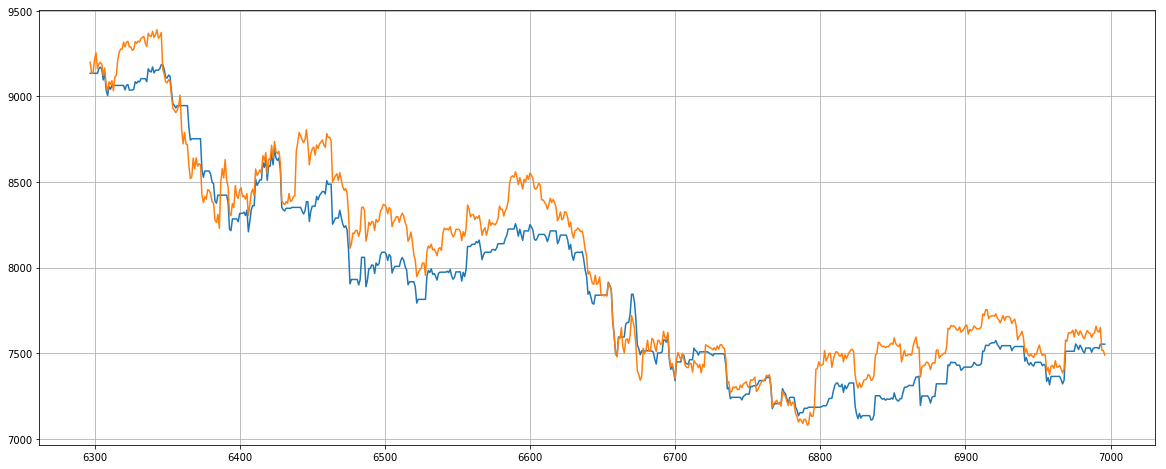

In [31]:
plt.figure(figsize=(20,8))
plt.plot(Indices_Test_FA,History)
plt.plot(Indices_Test_FA,Close_Price_FA[Indices_Test_FA[0]+Window_Lengt+1:])
plt.grid(True)
plt.show()

El modelo no se ajusta adecuadamente a esta porción de la serire de tiempo

## Linear Discriminant Analysis 

Parece que el clasificador LDA no da predicciones confiables, por ahora lo único que hace es predecir con igual probailidad las tres clases.

## Red Neuronal 

La red neuronal parece beneficiarse de pequeños números, es decir, no utilizar valores muy grandes como lo pueden ser el precio del BTC o grandes volumenes de compra y venta

In [32]:
from sklearn.neural_network import MLPClassifier

### Atributos del articulo 

In [33]:
#Se crea el clasificador tipo Multilayer Perceptron y se entrena
Neural_Network_CLS = MLPClassifier(activation='logistic',hidden_layer_sizes=(100,250,150,50),max_iter=500,random_state=0,solver='adam')
Neural_Network_CLS.fit(Train_X_DF,Data_Y_Train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 250, 150, 50), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [34]:
print('Presicion para entrenamiento: ',accuracy_score(Data_Y_Train, Neural_Network_CLS.predict(Train_X_DF)))
print('Presicion para testeo: ',accuracy_score(Data_Y_Validation, Neural_Network_CLS.predict(Validation_X_DF)))

Presicion para entrenamiento:  0.5352867607646954
Presicion para testeo:  0.5414285714285715


In [35]:
P1=1.0
P2=1.0
Confidence_Threshold,Efectividad_Porcetaje_Ganancia,Cantidad_Trades=Ganancia_Vs_Threshold(Neural_Network_CLS,Data_Y_Validation,Validation_X_DF,P1,P2,Indices_Validation,Window_Lengt,Close_Price)

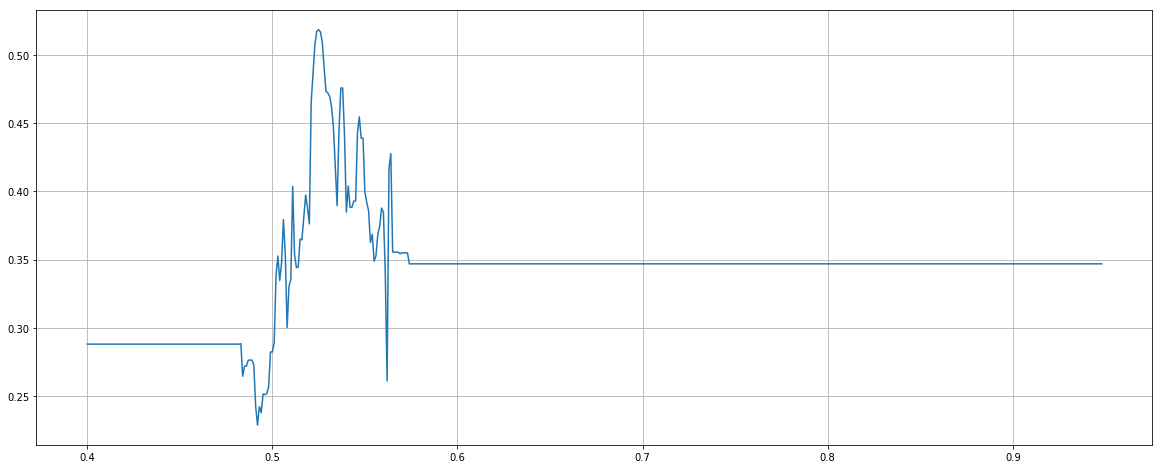

In [36]:
plt.figure(figsize=(20,8))
plt.plot(Confidence_Threshold,Efectividad_Porcetaje_Ganancia)
plt.grid(True)
plt.show()

In [37]:
Threshold=Confidence_Threshold[np.argmax(Efectividad_Porcetaje_Ganancia)]
Threshold

0.525

In [38]:
#Se observa cómo el algoritmo se comporta en el conjunto de testeo
Predictions = Neural_Network_CLS.predict(Test_X_DF)
Probabilities_of_Predictions = Neural_Network_CLS.predict_proba(Test_X_DF)
P1=1.0
P2=1.0
History, Movimientos = Ganancia(Predictions,Probabilities_of_Predictions,Data_Y_Test,P1,P2,Window_Lengt,Close_Price,0.5,Indices_Test)

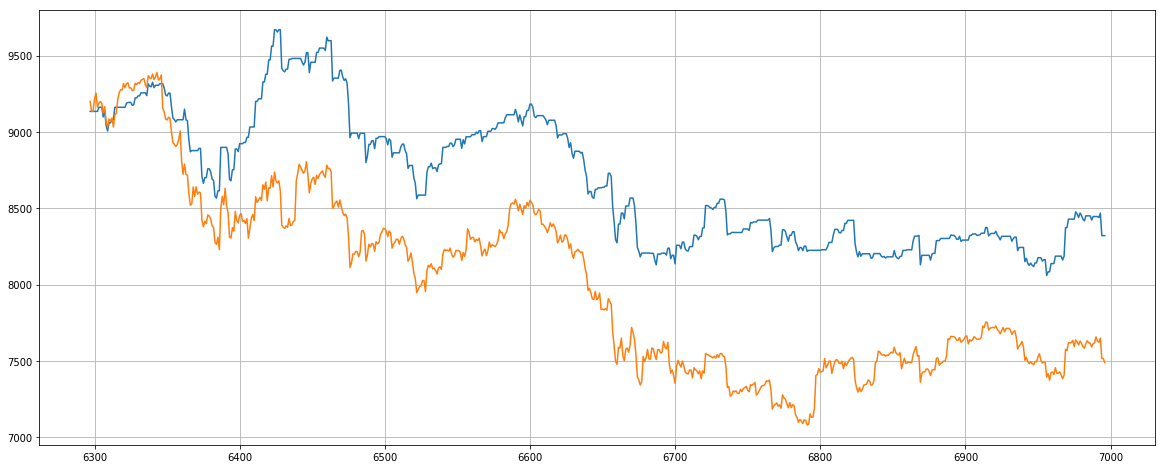

In [39]:
plt.figure(figsize=(20,8))
plt.plot(Indices_Test,History)
plt.plot(Indices_Test,Close_Price[Indices_Test[0]+Window_Lengt+1:])
plt.grid(True)
plt.show()

El modelo no se ajusta adecuadamente a esta porción de la serie de tiempo

### Atributos propuestos por nosotros

In [48]:
#Se crea el clasificador tipo Multilayer Perceptron y se entrena
Neural_Network_CLS = MLPClassifier(activation='logistic',hidden_layer_sizes=(120,200,150,80),max_iter=500,random_state=0,solver='adam')
Neural_Network_CLS.fit(Train_X_DF_FA,Data_Y_Train_FA)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(120, 200, 150, 80), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=0, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [49]:
print('Presicion para entrenamiento: ',accuracy_score(Data_Y_Train_FA, Neural_Network_CLS.predict(Train_X_DF_FA)))
print('Presicion para testeo: ',accuracy_score(Data_Y_Validation_FA, Neural_Network_CLS.predict(Validation_X_DF_FA)))


Presicion para entrenamiento:  0.5393961050562801
Presicion para testeo:  0.5171428571428571


In [50]:
P1=1.0
P2=1.0
Confidence_Threshold,Efectividad_Porcetaje_Ganancia,Cantidad_Trades=Ganancia_Vs_Threshold(Neural_Network_CLS,Data_Y_Validation_FA,Validation_X_DF_FA,P1,P2,Indices_Validation_FA,Window_Lengt,Close_Price_FA)

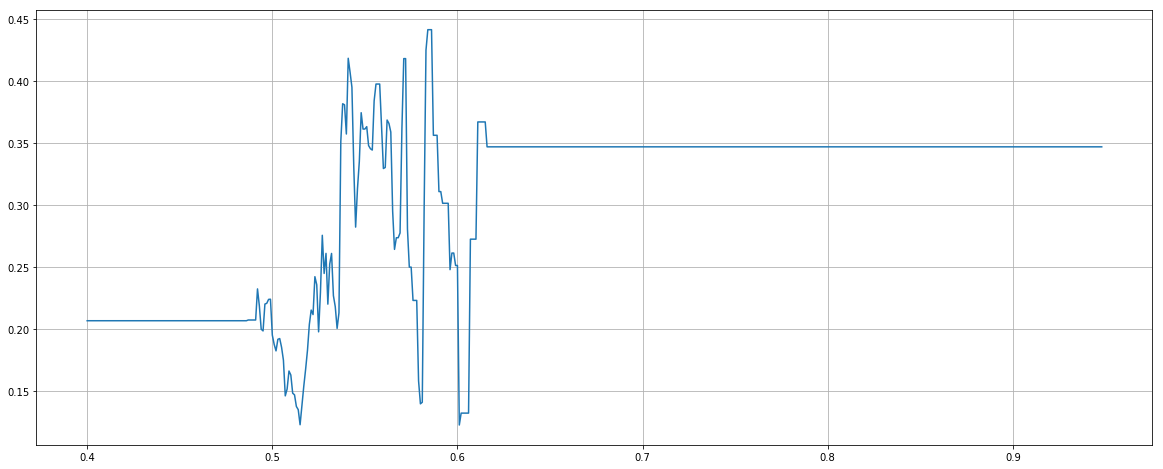

In [51]:
plt.figure(figsize=(20,8))
plt.plot(Confidence_Threshold,Efectividad_Porcetaje_Ganancia)
plt.grid(True)
plt.show()

In [52]:
Threshold=Confidence_Threshold[np.argmax(Efectividad_Porcetaje_Ganancia)]
Threshold

0.5840000000000001

In [53]:
#Se observa cómo el algoritmo se comporta en el conjunto de testeo
Predictions = Neural_Network_CLS.predict(Test_X_DF_FA)
Probabilities_of_Predictions = Neural_Network_CLS.predict_proba(Test_X_DF_FA)
P1=1.0
P2=1.0
History, Movimientos = Ganancia(Predictions,Probabilities_of_Predictions,Data_Y_Test_FA,P1,P2,Window_Lengt,Close_Price_FA,Threshold,Indices_Test_FA)

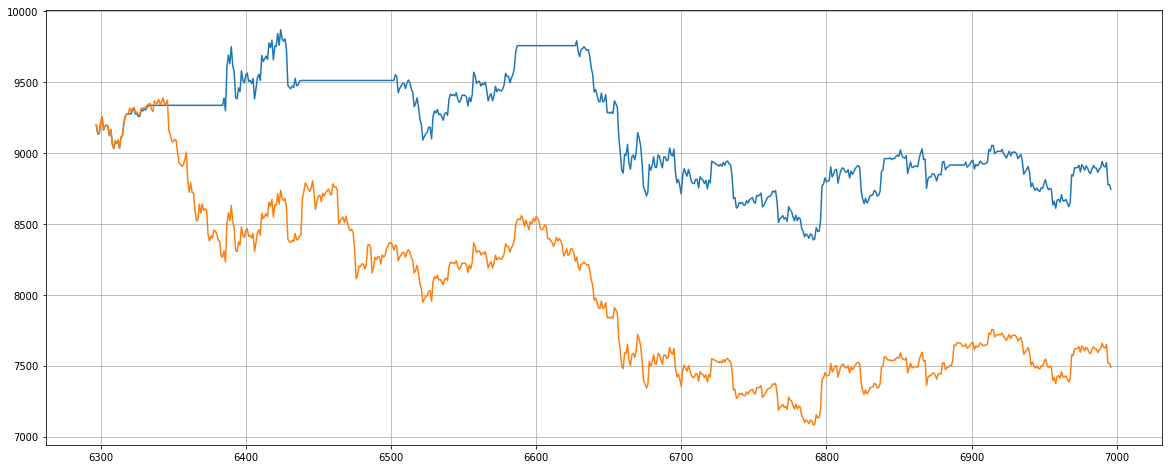

In [54]:
plt.figure(figsize=(20,8))
plt.plot(Indices_Test_FA,History)
plt.plot(Indices_Test_FA,Close_Price_FA[Indices_Test_FA[0]+Window_Lengt+1:])
plt.grid(True)
plt.show()

El modelo no se comporta edecuadamente en esta sección de la serie